In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

# %%
spark = SparkSession.builder \
    .appName("SECOP_RegresionLineal") \
    .master("spark://spark-master:7077") \
    .getOrCreate()

print(f"Spark Version: {spark.version}")
print(f"Spark Master: {spark.sparkContext.master}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/09 02:12:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Version: 3.5.0
Spark Master: spark://spark-master:7077


26/02/09 02:13:04 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [3]:
# Cargar datos
df = spark.read.parquet("/opt/spark-data/raw/secop_ml_ready.parquet")

# Renombrar columnas para consistencia
df = df.withColumnRenamed("valor_del_contrato_num", "label") \
       .withColumnRenamed("features_pca", "features")

# Filtrar valores nulos
df = df.filter(col("label").isNotNull())
print(f"Registros: {df.count():,}")
print(f"Columnas: {len(df.columns)}")

Registros: 100,000
Columnas: 2


### **Definir estrategia de train/test split**

Estrategia definida: 70% entrenamiento, 30% prueba

In [5]:
train_ratio = 0.7
test_ratio = 0.3

train, test = df.randomSplit([train_ratio,test_ratio],
                             seed = 45 #Reproducibilidad
                            )

print("\n=== TRAIN / TEST SPLIT ===")
print(f"Train: {train.count():,} registros ({train_ratio*100:.0f}%)")
print(f"Test:  {test.count():,} registros ({test_ratio*100:.0f}%)")


=== TRAIN / TEST SPLIT ===


Train: 70,122 registros (70%)


Test:  29,878 registros (30%)


### *Configurar modelo de LinearRegression**

In [6]:
lr = LinearRegression(featuresCol="features",
                     labelCol="label",
                     maxIter=100, # Iteraciones suficientes para converger
                     regParam=0.0,  # Sin regularización (baseline)
                     elasticNetParam=0.0) # No aplica sin regularización

print("✓ Modelo de Regresión Lineal configurado")
print(f"  featuresCol: {lr.getFeaturesCol()}")
print(f"  labelCol:    {lr.getLabelCol()}")
print(f"  maxIter:     {lr.getMaxIter()}")
print(f"  regParam:    {lr.getRegParam()}")
print(f"  elasticNet:  {lr.getElasticNetParam()}")

✓ Modelo de Regresión Lineal configurado
  featuresCol: features
  labelCol:    label
  maxIter:     100
  regParam:    0.0
  elasticNet:  0.0


## **Interpretar R² del modelo**

In [7]:
print("Entrenando modelo de regresión lineal...")
lr_model = lr.fit(train)

print("✓ Modelo entrenado")
print(f"Solver utilizado: {lr_model.getSolver()}")


Entrenando modelo de regresión lineal...


26/02/09 02:31:36 WARN Instrumentation: [a0186192] regParam is zero, which might cause numerical instability and overfitting.
26/02/09 02:31:39 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
26/02/09 02:31:39 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
26/02/09 02:31:39 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


✓ Modelo entrenado
Solver utilizado: auto


In [8]:
# %%
r2_train = lr_model.summary.r2
rmse_train = lr_model.summary.rootMeanSquaredError

print("\n=== MÉTRICAS EN TRAIN ===")
print(f"R² (train):  {r2_train:.4f}")
print(f"RMSE (train): ${rmse_train:,.2f}")



=== MÉTRICAS EN TRAIN ===
R² (train):  0.5648
RMSE (train): $3,074,544,375.61


### **Analizar calidad de predicciones y errores**

In [10]:
predictions= lr_model.transform(test)
print("\n=== EJEMPLO DE PREDICCIONES ===")
predictions.select("label", "prediction").show(10, truncate=False)


=== EJEMPLO DE PREDICCIONES ===
+---------+--------------------+
|label    |prediction          |
+---------+--------------------+
|945000.0 |-3.764113971645652E8|
|1250000.0|-3.7626297676421E8  |
|1950000.0|-3.75922339779788E8 |
|1950000.0|-3.75922339779788E8 |
|1950000.0|-3.75922339779788E8 |
|1950000.0|-3.75922339779788E8 |
|1950000.0|-3.75922339779788E8 |
|1950000.0|-3.75922339779788E8 |
|1950000.0|-3.75922339779788E8 |
|1950000.0|-3.75922339779788E8 |
+---------+--------------------+
only showing top 10 rows



In [11]:
from pyspark.sql.functions import abs as spark_abs

predictions_with_error = predictions.withColumn(
    "absolute_error",
    spark_abs(col("prediction") - col("label"))
)

print("\n=== PREDICCIONES CON ERROR ABSOLUTO ===")
predictions_with_error.select(
    "label", "prediction", "absolute_error"
).show(10, truncate=False)

print("\n=== TOP 10 PEORES PREDICCIONES (MAYOR ERROR) ===")

predictions_with_error \
    .orderBy(col("absolute_error").desc()) \
    .select("label", "prediction", "absolute_error") \
    .show(10, truncate=False)

# %%
print("\n=== TOP 10 PEORES PREDICCIONES (MAYOR ERROR) ===")

predictions_with_error \
    .orderBy(col("absolute_error").desc()) \
    .select("label", "prediction", "absolute_error") \
    .show(10, truncate=False)



=== PREDICCIONES CON ERROR ABSOLUTO ===
+---------+--------------------+-------------------+
|label    |prediction          |absolute_error     |
+---------+--------------------+-------------------+
|945000.0 |-3.764113971645652E8|3.773563971645652E8|
|1250000.0|-3.7626297676421E8  |3.7751297676421E8  |
|1950000.0|-3.75922339779788E8 |3.77872339779788E8 |
|1950000.0|-3.75922339779788E8 |3.77872339779788E8 |
|1950000.0|-3.75922339779788E8 |3.77872339779788E8 |
|1950000.0|-3.75922339779788E8 |3.77872339779788E8 |
|1950000.0|-3.75922339779788E8 |3.77872339779788E8 |
|1950000.0|-3.75922339779788E8 |3.77872339779788E8 |
|1950000.0|-3.75922339779788E8 |3.77872339779788E8 |
|1950000.0|-3.75922339779788E8 |3.77872339779788E8 |
+---------+--------------------+-------------------+
only showing top 10 rows


=== TOP 10 PEORES PREDICCIONES (MAYOR ERROR) ===
+----------------+---------------------+---------------------+
|label           |prediction           |absolute_error       |
+--------------

In [13]:
# %%
predictions_with_error = predictions_with_error.withColumn(
    "error_porcentual",
    (col("absolute_error") / col("label")) * 100
)

print("\n=== EJEMPLO DE ERROR PORCENTUAL ===")
predictions_with_error.select(
    "label", "prediction", "error_porcentual"
).show(10, truncate=False)



=== EJEMPLO DE ERROR PORCENTUAL ===
+---------+--------------------+------------------+
|label    |prediction          |error_porcentual  |
+---------+--------------------+------------------+
|945000.0 |-3.764113971645652E8|39931.893879848176|
|1250000.0|-3.7626297676421E8  |30201.038141136796|
|1950000.0|-3.75922339779788E8 |19378.068706655795|
|1950000.0|-3.75922339779788E8 |19378.068706655795|
|1950000.0|-3.75922339779788E8 |19378.068706655795|
|1950000.0|-3.75922339779788E8 |19378.068706655795|
|1950000.0|-3.75922339779788E8 |19378.068706655795|
|1950000.0|-3.75922339779788E8 |19378.068706655795|
|1950000.0|-3.75922339779788E8 |19378.068706655795|
|1950000.0|-3.75922339779788E8 |19378.068706655795|
+---------+--------------------+------------------+
only showing top 10 rows



## **Comparar train vs test para detectar overfitting**

In [17]:
evaluator_rmse = RegressionEvaluator(labelCol="label",
                                    predictionCol="prediction",
                                    metricName="rmse")

evaluator_mae = RegressionEvaluator(labelCol="label",
                                    predictionCol="prediction",
                                    metricName="mae")

evaluator_r2 = RegressionEvaluator(labelCol="label",
                                    predictionCol="prediction",
                                    metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("\n=== MÉTRICAS EN TEST ===")
print("rmse:", rmse)
print("mae:",mae)
print("r2:",r2)

print("="*60)

print("\n=== COMPARACIÓN TRAIN VS TEST ===")
print(f"R² Train: {lr_model.summary.r2:.4f}")
print(f"R² Test:  {r2:.4f}")
print(f"Diferencia absoluta: {abs(lr_model.summary.r2 - r2):.4f}")


=== MÉTRICAS EN TEST ===
rmse: 3048622156.1168594
mae: 587881077.4199551
r2: 0.574245194499015

=== COMPARACIÓN TRAIN VS TEST ===
R² Train: 0.5648
R² Test:  0.5742
Diferencia absoluta: 0.0095


### **Analizar coeficientes del modelo**

In [18]:
coefficients = lr_model.coefficients
intercept = lr_model.intercept

print(f"Intercepto: {intercept:,.2f}")
print(f"Número de coeficientes: {len(coefficients)}")

Intercepto: 289,073,028.13
Número de coeficientes: 30


### **Analisis de distribucion de residuos**

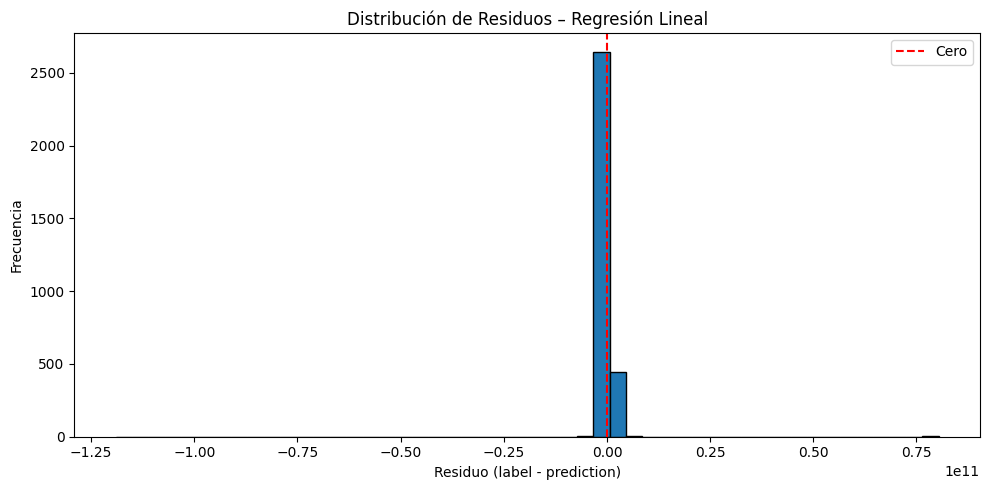

In [19]:
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt

# Calcular residuos
residuals_df = predictions.withColumn(
    "residual",
    col("label") - col("prediction")
)

# Tomar muestra para visualización
residuals_sample = residuals_df.select("residual") \
    .sample(0.1, seed=42) \
    .toPandas()

# Histograma de residuos
plt.figure(figsize=(10, 5))
plt.hist(residuals_sample["residual"], bins=50, edgecolor="black")
plt.axvline(0, color="red", linestyle="--", label="Cero")
plt.xlabel("Residuo (label - prediction)")
plt.ylabel("Frecuencia")
plt.title("Distribución de Residuos – Regresión Lineal")
plt.legend()
plt.tight_layout()

plt.show()


### **Feature importance aproximado**

In [21]:
import numpy as np

coef_array = np.array(lr_model.coefficients)
abs_coefs = np.abs(coef_array)

# Top 10 componentes más influyentes
top_idx = np.argsort(abs_coefs)[-10:]

print("\n=== TOP 10 COMPONENTES PCA MÁS IMPORTANTES ===")
for rank, idx in enumerate(reversed(top_idx), start=1):
    print(
        f"{rank}. PC{idx+1} | "
        f"Coeficiente: {coef_array[idx]:.6f} | "
        f"|Coef|: {abs_coefs[idx]:.6f}"
    )



=== TOP 10 COMPONENTES PCA MÁS IMPORTANTES ===
1. PC8 | Coeficiente: -1894119859.009920 | |Coef|: 1894119859.009920
2. PC9 | Coeficiente: 1759280137.619244 | |Coef|: 1759280137.619244
3. PC7 | Coeficiente: 1528428530.389889 | |Coef|: 1528428530.389889
4. PC3 | Coeficiente: 746143548.444401 | |Coef|: 746143548.444401
5. PC10 | Coeficiente: -424929666.922068 | |Coef|: 424929666.922068
6. PC1 | Coeficiente: 365979814.538961 | |Coef|: 365979814.538961
7. PC6 | Coeficiente: -365618991.251486 | |Coef|: 365618991.251486
8. PC4 | Coeficiente: -331789449.887774 | |Coef|: 331789449.887774
9. PC26 | Coeficiente: -309917889.844691 | |Coef|: 309917889.844691
10. PC16 | Coeficiente: 301168112.642653 | |Coef|: 301168112.642653


In [22]:
# Guardar modelo
model_path = "/opt/spark-data/raw/linear_regression_model"
lr_model.save(model_path)
print(f"\nModelo guardado en: {model_path}")

# %%
# Guardar predicciones
predictions_path = "/opt/spark-data/raw/predictions_lr.parquet"
predictions.write.mode("overwrite").parquet(predictions_path)
print(f"Predicciones guardadas en: {predictions_path}")

# %%
spark.stop()


Modelo guardado en: /opt/spark-data/raw/linear_regression_model


Predicciones guardadas en: /opt/spark-data/raw/predictions_lr.parquet
